## Single-cancer holdout dimension reduction analysis

Following [this GitHub issue](https://github.com/greenelab/pancancer-evaluation/issues/39) and related discussions in lab meeting, we wanted to look at how separable the data is in the 95% holdout cases where performance isn't decreasing. Our hypothesis is that in the cases where performance is fairly consistent, the data is very close to linearly separable, allowing us to easily train a decent classifier even from very little training data.

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.analysis_utilities as au

In [2]:
# load gene expression and mutation data
from pancancer_evaluation.data_models.tcga_data_model import TCGADataModel

tcga_data = TCGADataModel(seed=cfg.default_seed,
                          subset_mad_genes=cfg.num_features_raw,
                          verbose=True,
                          debug=False)

Loading gene expression data...
Loading sample info...
Loading pan-cancer data from cached pickle file...


In [3]:
# for a given gene and holdout percentage, generate reduced dimensional
# representation of train/test data
from sklearn.decomposition import PCA
from umap import UMAP

from pancancer_evaluation.utilities import data_utilities as du
from pancancer_evaluation.utilities import tcga_utilities as tu

pca = PCA(n_components=2)
umap = UMAP(n_components=2)

def generate_rep_holdout(gene, cancer_type, percent_holdout, method='pca'):
    identifier = '{}_{}'.format(gene, cancer_type)
    classification = du.get_classification(gene)
    tcga_data.process_data_for_identifiers(identifier,
                                           identifier,
                                           classification,
                                           classification,
                                           output_dir=None,
                                           shuffle_labels=False,
                                           percent_holdout=percent_holdout,
                                           holdout_class='both')
    # this step standardizes columns and filters features by MAD
    X_train, X_test = tu.preprocess_data(tcga_data.X_train_raw_df,
                                         tcga_data.X_test_raw_df,
                                         tcga_data.gene_features,
                                         tcga_data.subset_mad_genes)
    # now take PCA and return 2-dimensional representation
    if method == 'pca':
        train_rep = pca.fit_transform(X_train)
        test_rep = pca.fit_transform(X_test)
    elif method == 'umap':
        train_rep = umap.fit_transform(X_train)
        test_rep = umap.fit_transform(X_test)
    # also return corresponding mutation labels
    train_labels = tcga_data.y_train_df.status.values
    test_labels = tcga_data.y_test_df.status.values
    return (train_rep, test_rep, train_labels, test_labels)

X, _, __, ___ = generate_rep_holdout('TP53', 'GBM', 0.5)
print(X.shape)
print(X[:5, :])

(62, 2)
[[-24.86078919 -19.84701966]
 [-71.78214107 -14.96675691]
 [ 14.85002665  73.82339542]
 [  4.25661987  46.87962647]
 [-98.60069106 -36.12117675]]


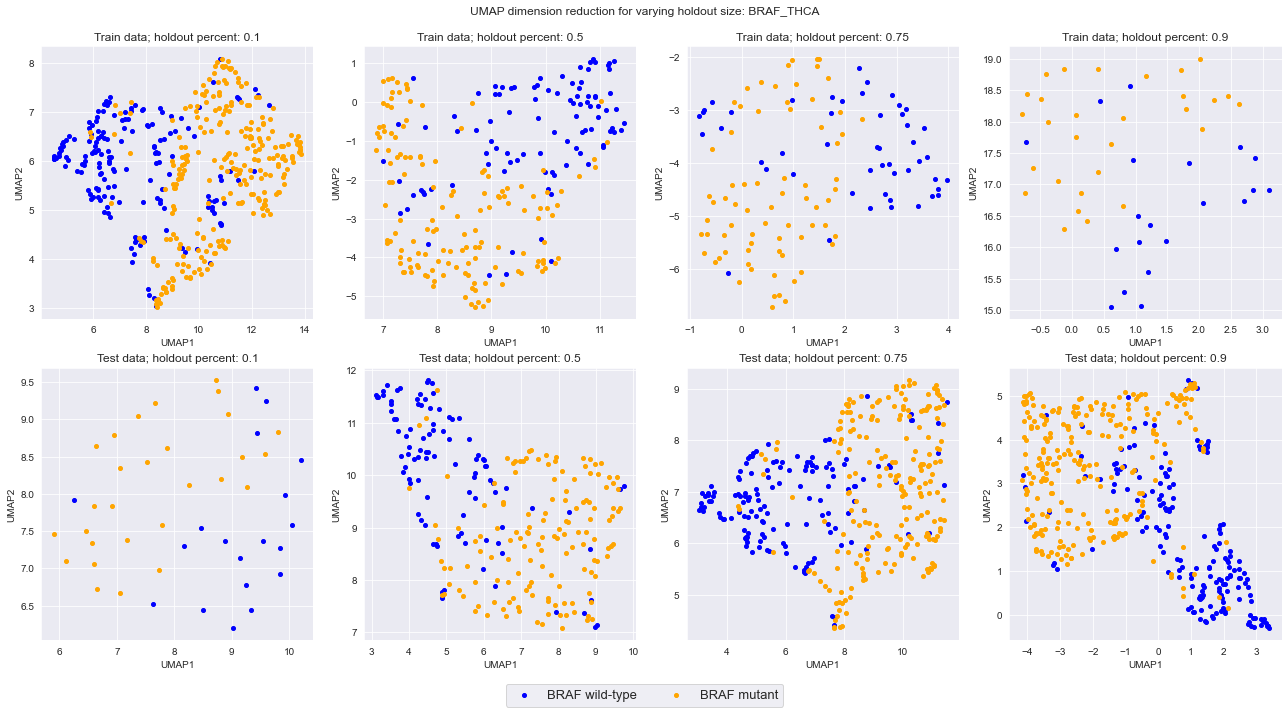

In [4]:
gene = 'BRAF'
cancer_type = 'THCA'
projection_method = 'umap'
remove_percents = [0.1, 0.5, 0.75, 0.9]
sns.set({'figure.figsize': (18, 10)})

fig, axarr = plt.subplots(2, len(remove_percents))

z_label = '{} wild-type'.format(gene)
nz_label = '{} mutant'.format(gene)
x_label = '{}1'.format(projection_method.upper())
y_label = '{}2'.format(projection_method.upper())

for ix, remove_percent in enumerate(remove_percents):
    ax0 = axarr[0, ix]
    ax1 = axarr[1, ix]
    rep = generate_rep_holdout(gene, cancer_type, remove_percent, method=projection_method)
    X_tr_train, X_tr_test, y_train, y_test = rep
    ax0.scatter(x=X_tr_train[y_train == 0, 0], y=X_tr_train[y_train == 0, 1], color='blue', label=z_label, s=16)
    ax0.scatter(x=X_tr_train[y_train == 1, 0], y=X_tr_train[y_train == 1, 1], color='orange', label=nz_label, s=16)
    ax0.set_xlabel(x_label)
    ax0.set_ylabel(y_label)
    ax0.set_title('Train data; holdout percent: {}'.format(remove_percent))
    ax1.scatter(x=X_tr_test[y_test == 0, 0], y=X_tr_test[y_test == 0, 1], color='blue', label=z_label, s=16)
    ax1.scatter(x=X_tr_test[y_test == 1, 0], y=X_tr_test[y_test == 1, 1], color='orange', label=nz_label, s=16)
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    ax1.set_title('Test data; holdout percent: {}'.format(remove_percent))

plt.tight_layout()
labels = [z_label, nz_label]
fig.suptitle('{} dimension reduction for varying holdout size: {}_{}'.format(
    projection_method.upper(), gene, cancer_type))
fig.legend(labels=labels, loc='lower center', ncol=2, fontsize=13)
fig.subplots_adjust(top=0.925, bottom=0.1)

Running the above cell for a few different gene/cancer type combinations shows that in most of the cases where performance is fairly consistent across holdout data percentages (e.g. BRAF_THCA, TP53_LGG) the data is fairly close to being linearly separable. In other words, in these cases data appears to (roughly) cluster by mutation status.

In cases where performance decreases (e.g. EGFR_LUAD, TP53_SKCM, TP53_BLCA) this isn't necessarily the case; mutated samples seem to be more or less randomly distributed throughout the point cloud.

This doesn't really seem to depend on the dimension reduction method used (PCA and UMAP for the most part give similar results), although UMAP clusters probably look a bit nicer/more well-separated in some cases.

Thus, the results seem to suggest that what we're seeing is a real trend in the data (some mutations are just very resistant to removing training data), rather than a bug or a characteristic of the performance metric we chose.

In [5]:
# reproduce the line plot from plot_holdout_single_cancer, but only for one gene
# this will put the above plots in context
results_dir = os.path.join(cfg.results_dir,
                           'cross_cancer',
                           'cross_cancer_flip_counts',
                           'cross_cancer_flip_labels')
holdout_df = (
    au.load_flip_labels_results(results_dir, 'flip_labels')
      .sort_values(by=['train_identifier', 'test_identifier',
                       'percent_holdout', 'signal'])
)

holdout_norm_df = au.normalize_to_control(holdout_df,
                                          train_id='train_identifier',
                                          test_id='test_identifier',
                                          additional_cols=['percent_holdout'])
holdout_norm_df = (
    holdout_norm_df.assign(gene=lambda x: x.train_identifier.str.split('_', expand=True)[0],
                           cancer_type=lambda x: x.train_identifier.str.split('_', expand=True)[1])
                   .drop(columns=['train_identifier', 'test_identifier'])
                   .reset_index(drop=True)
)
holdout_norm_df['identifier'] = holdout_norm_df.gene + '_' + holdout_norm_df.cancer_type
holdout_norm_df.head()

,percent_holdout,aupr,gene,cancer_type,identifier
0,0.10,0.517707,TP53,PRAD,TP53_PRAD
1,0.10,0.021570,TP53,LUSC,TP53_LUSC
2,0.10,0.894433,EGFR,LUAD,EGFR_LUAD
3,0.10,0.075000,TP53,KICH,TP53_KICH
4,0.25,0.340810,KRAS,COAD,KRAS_COAD


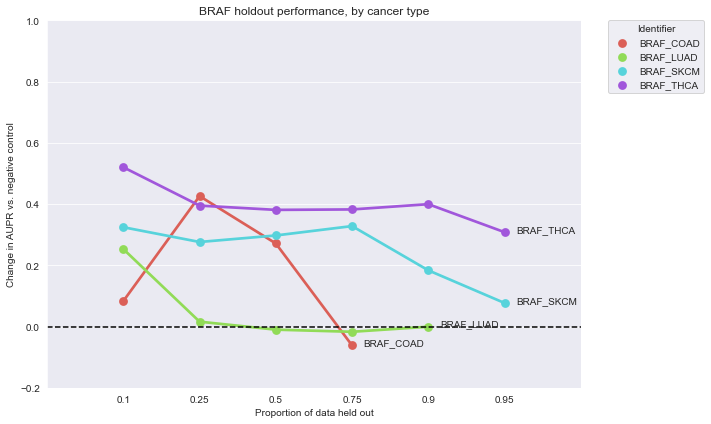

In [6]:
sns.set({'figure.figsize': (10, 6)})
plot_df = (
    holdout_norm_df[(holdout_norm_df.gene == gene)].sort_values(by='cancer_type')
)
g = sns.pointplot(data=plot_df, x='percent_holdout', y='aupr', hue='identifier',
                  palette='hls')
plt.xlabel('Proportion of data held out')
plt.ylabel('Change in AUPR vs. negative control')
plt.ylim(-0.2, 1.0)
plt.title('{} holdout performance, by cancer type'.format(gene))
plt.legend(title='Identifier', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.axhline(y=0, color='black', linestyle='--')
plt.tight_layout()

# calculate the last percent where we have enough data
# (most should be close to 1, but some small cancer types won't be)
last_points = (
    holdout_norm_df.groupby(['identifier'])
                   .max()['percent_holdout']
                   .to_dict()
)

# label cancer types to the right of line, this is much easier to read than colormap
def label_points(x, y, identifier, ax):
    x_offset = 0.15
    y_offset = 0
    x_categories = np.sort(np.unique(x.values))
    a = pd.DataFrame({'x': x, 'y': y, 'identifier': identifier})
    for i, point in a.iterrows():
        # only label last point in line plot
        if point['x'] == last_points[point['identifier']]:
            # x-axis is actually categorical ("fake" continuous)
            # so we have to map to the index of the category we want to label
            x_loc = np.where(x_categories == point['x'])[0]
            ax.text(x_loc+x_offset, point['y']+y_offset, str(point['identifier']))
    
label_points(plot_df.percent_holdout,
             plot_df.aupr,
             plot_df.identifier,
             plt.gca())
plt.gca().margins(x=0.2)